In [1]:
#In this notebook, I am trying to show usage of Bert and how to fine tune.


In [2]:
import warnings
warnings.simplefilter('ignore')
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn import metrics
import transformers
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import DistilBertTokenizer, DistilBertModel
import logging
logging.basicConfig(level=logging.ERROR)

from transformers import BertTokenizer, BertModel, BertForMaskedLM
from scipy.spatial.distance import cosine
import torch
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import spacy
import numpy as np
import matplotlib

In [3]:
#Bert utility methods to use in this tutorial. these methods are not optimized
#because it processes 1-by-1 , in real usage these methods must process multi-sentences at once


#Bert model returns 3 things : last_hidden_state, pooler_output, hidden_states
#last_hidden_state : last output of network [batch x seq_len x 768]
#pooler_output : the ouput of last piece of network [batch  x 768]
#hidden_states : all outputs of all layers(13 layers) each [batch x seq_len x 768]
def get_bert_output(tokenizer_,model_,sentence):
  bert_text = "[CLS] " + sentence + " [SEP]"
  tokenized_text = tokenizer_.tokenize(bert_text)
  indexed_tokens = tokenizer_.convert_tokens_to_ids(tokenized_text)
  segments_ids = [1] * len(tokenized_text)
  tokens_tensor = torch.tensor([indexed_tokens])
  segments_tensors = torch.tensor([segments_ids])
  
  outputs = model_(tokens_tensor, segments_tensors)
  return outputs  

#pooler is layer after transformers , use this output for classification tasks
#  (pooler): BertPooler(
#    (dense): Linear(in_features=768, out_features=768, bias=True)
#    (activation): Tanh()
#  )
def get_bert_output_pooled(tokenizer_,model_,sentence):  
  outputs = get_bert_output(tokenizer_,model_,sentence)
  output_pooled =  outputs["pooler_output"] 
  return output_pooled.squeeze()  

#last hidden state of CLS token represents sentence embedding
def get_bert_output_cls(tokenizer_,model_,sentence):    
  outputs = get_bert_output(tokenizer_,model_,sentence) 
  cls_output = outputs["last_hidden_state"].squeeze()[0]
  return cls_output


#hidden layers are 1 initial embedding + 12 bert tranformer = 13 layers
def get_bert_hidden_layers(tokenizer_,model_,sentence):
  outputs = get_bert_output(tokenizer_,model_,sentence)
  hidden_states = outputs["hidden_states"]
  return hidden_states  

#try different architectures that best fits your problem ,
#I can give combination of different layers and try which combination of hidden states best fit to
#your target problem
def get_sentence_embedding(tokenizer_,model_,sentence,layer_start=-4,layer_end=None,type="sumsum"):
  hidden_states = get_bert_hidden_layers(tokenizer_,model_,sentence)
  effective_layers = torch.stack(hidden_states[layer_start:layer_end])
  
  if type == "sumsum":
    sentence_embedding = torch.sum(effective_layers.sum(0).squeeze(), dim=0) 
  elif type == "summean":  
    sentence_embedding = torch.sum(effective_layers.mean(0).squeeze(), dim=0) 
  elif type == "meanmean":  
    sentence_embedding = torch.mean(effective_layers.mean(0).squeeze(), dim=0)    
  else:
    sentence_embedding = torch.mean(effective_layers.sum(0).squeeze(), dim=0)      

  return sentence_embedding



#all hidden transformer states
def get_bert_transformer_layers(tokenizer_,model_,sentence):  
  hidden_states = get_bert_hidden_layers(tokenizer_,model_,sentence)

  token_embeddings = torch.tensor( [h.detach().numpy() for h in hidden_states[1:]])
  token_embeddings = token_embeddings.squeeze()
  token_embeddings = token_embeddings.permute(1,0,2)
  return token_embeddings

 


#best practise is concating last 4 layers
#Steps to create a word embedding
#1) get all transformer layer outputs(12x768 for 1 word)
#2) do a summarization of 12 vector(mean,sum,pool,concat ...)
def get_word_embeddings_sum(tokenizer_,model_,sentence) :
  token_embeddings = get_bert_transformer_layers(tokenizer_,model_,sentence)  
  word_embeddings = []
  for token in token_embeddings:
    #torch.cat((token[-1], token[-2], token[-3], token[-4]), dim=0)        
    sum_vec = torch.sum(token[-4:], dim=0)   
    word_embeddings.append(sum_vec)

  return word_embeddings 

class EmbeddingPair:
  def __init__(self,word,vector):
    self.word = word
    self.vector = vector

#return token -> token_embedding as pairs.    
def get_embeddings_as_pair(tokenizer_,model_,sentence,embeddings):
  bert_text = "[CLS] " + sentence + " [SEP]"
  tokenized_text = tokenizer_.tokenize(bert_text)
  return [ EmbeddingPair(tokenized_text[index] , embeddings[index]) for index in range(len(tokenized_text)) ]


#given a sentence only return the embeddings of specified word
#just my utility method for easy visualization
def get_word_embeddings(tokenizer_,model_,sentence,word):
  embeddings = get_word_embeddings_sum(tokenizer_,model_, sentence )
  embeddings_as_pairs = get_embeddings_as_pair(tokenizer_,model_,sentence,embeddings)
  word_embeddings = []
  for pair in embeddings_as_pairs:
    if pair.word == word:
      word_embeddings.append( pair )
  return word_embeddings  

def get_similarity(vector1,vector2):
  return 1 - cosine(vector1, vector2)  
  
  






In [4]:
#TODO remove color parts
#def get_color(s): if s.find("eat")


def map_on_3d(data_2d,words,color_mapping:None,exceptional_words=[],use_word_colors=False,fig_size=[19,11],title=""):
    fig = matplotlib.pyplot.gcf()
    fig.set_size_inches(fig_size[0], fig_size[1])

    ax = plt.axes(projection ="3d")
    #scatter result words
    ax.scatter3D(data_2d[:, 0], data_2d[:, 1], data_2d[:, 2])
    plt.title(title)        
    #put an annotation on x,y cordinates for words
    for i, word in enumerate(words):
        if color_mapping is not None:
            ax.text(data_2d[i, 0], data_2d[i, 1], data_2d[i, 2],word,color=color_mapping[i] )
        elif word in exceptional_words:
            ax.text(data_2d[i, 0], data_2d[i, 1], data_2d[i, 2],word,color='#0000ff' )
        elif use_word_colors:
            ax.text(data_2d[i, 0], data_2d[i, 1], data_2d[i, 2],word,color=get_color(word))
        elif "eat" in word:
            ax.text(data_2d[i, 0], data_2d[i, 1], data_2d[i, 2],word,color='#0000ff')
        elif "drink" in word:
            ax.text(data_2d[i, 0], data_2d[i, 1], data_2d[i, 2],word,color='#00ff00')
        elif "read" in word:
            ax.text(data_2d[i, 0], data_2d[i, 1], data_2d[i, 2],word,color='#ff0000')     
        else:
            ax.text(data_2d[i, 0], data_2d[i, 1], data_2d[i, 2],word,color='#ff00dd')
    plt.show()

def get_color_mapping(Ys,color_by="verb"):
  
  mapped_colors = []
  if color_by == "verb":    
    colors =["#ff0000","#00dd00","#0000dd"] 
    verbs = ["eat","drink"," read"] #bread has "read" process carefully
    for y in Ys:
      indexes = [i for i,verb in enumerate(verbs) if y.find(verb) > -1]
      mapped_colors.append(colors[indexes[0]] )

  if color_by == "object":    
    colors =["#ff0000","#aaaa00","#00ff00","#000220","#0000ff","#00aaaa"] 
    objects = ["apple","bread","water","beer","book","newspaper"]
    for y in Ys:
      indexes = [i for i,object in enumerate(objects) if y.find(object) > -1]
      mapped_colors.append(colors[indexes[0]] )    
    
  return mapped_colors  

def map_on_2d(data_2d,words,color_mapping:None,exceptional_words=[],use_word_colors=False,fig_size=[16,11],title=""):
    fig = matplotlib.pyplot.gcf()
    fig.set_size_inches(fig_size[0], fig_size[1])

    #scatter result words
    plt.scatter(data_2d[:, 0], data_2d[:, 1])        
    plt.title(title)
    #put an annotation on x,y cordinates for words
    for i, word in enumerate(words):
        if color_mapping is not None:
            plt.annotate(word, xy=(data_2d[i, 0], data_2d[i, 1]),color=color_mapping[i] )
        elif word in exceptional_words:
            plt.annotate(word, xy=(data_2d[i, 0], data_2d[i, 1]),color='#0000ff' )
        elif use_word_colors:
            plt.annotate(word, xy=(data_2d[i, 0], data_2d[i, 1]),color=get_color(word))
        elif "eat" in word:
            plt.annotate(word, xy=(data_2d[i, 0], data_2d[i, 1]),color='#0000ff')
        elif "drink" in word:
            plt.annotate(word, xy=(data_2d[i, 0], data_2d[i, 1]),color='#00ff00')
        elif "read" in word:
            plt.annotate(word, xy=(data_2d[i, 0], data_2d[i, 1]),color='#ff0000')     
        else:
            plt.annotate(word, xy=(data_2d[i, 0], data_2d[i, 1]),color='#ff00dd')
    plt.show()   

def dump_on_surface(Xs,Ys,fitting="tsne",dump_3d=True,dump_2d=True,color_by="verb",title=""):    
    color_mapping = get_color_mapping(Ys,color_by)
    #print(color_mapping)
                             
    if dump_3d:    
        X_transformed = None
        if fitting=="tsne":
          X_transformed = PCA(n_components=3).fit_transform(np.array(Xs))
        else:   
          X_transformed = TSNE(n_components=3).fit_transform(np.array(Xs))
        map_on_3d(np.array(X_transformed),Ys,color_mapping=color_mapping,use_word_colors=False,fig_size=[10,10],title=title)
    if dump_2d:    
        pca = PCA(n_components=2)
        X_transformed = pca.fit_transform(np.array(Xs))
        map_on_2d(np.array(X_transformed),Ys,color_mapping=color_mapping,use_word_colors=False,fig_size=[10,10],title=title)

In [5]:
# # Setting up the device for GPU usage

from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

In [6]:
sentences = ['i want to eat bread',
 'i want to eat apple',
 'i want to drink water',
 'i want to drink beer', 
 'i want to read book', 
 'i want to read newspaper',
 'i can eat bread', 
 'i can eat apple', 
 'i can drink water',
 'i can drink beer', 
 'i can read book', 
 'i can read newspaper',
 'we want to eat bread',
 'we want to eat apple',
 'we want to drink water',
 'we want to drink beer',
 'we want to read book', 
 'we want to read newspaper',
 'we can eat bread', 
 'we can eat apple', 
 'we can drink water',
 'we can drink beer', 
 'we can read book', 
 'we can read newspaper',
 'i eat bread', 
 'i eat apple', 
 'i drink water', 
 'i drink beer', 
 'i read book', 
 'i read newspaper',
 'we eat bread', 
 'we eat apple', 
 'we drink water',
 'we drink beer',
 'we read book', 
 'we read newspaper',
 ]
sentences[0]

'i want to eat bread'

In [7]:
MAX_LEN = 8


In [8]:
bert_model_nottrained = BertModel.from_pretrained('bert-base-uncased',output_hidden_states = True )
bert_model_nottrained.eval()
tokenizer_nottrained = DistilBertTokenizer.from_pretrained('distilbert-base-uncased', truncation=True, do_lower_case=True)


In [9]:
bert_model_nottrained

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

In [10]:
#Lets try to do 1 cycle of Bert encoding
sentence = "i eat apple"
#1) append [CLS] and [SEP]
bert_text = "[CLS] " + sentence + " [SEP]"

#2)Tokenize text
tokenized_text = tokenizer_nottrained.tokenize(bert_text)
print("tokenized_text :",tokenized_text)

#3)Convert tokens to ids in Bert vocublary
indexed_tokens = tokenizer_nottrained.convert_tokens_to_ids(tokenized_text)
print("indexed_tokens :",indexed_tokens)

#4)Prepare segment ids(since we have single sentence all 1)
segments_ids = [1] * len(tokenized_text)
print("segments_ids :",segments_ids)
#5)Convert to tensor and call model
tokens_tensor = torch.tensor([indexed_tokens])
segments_tensors = torch.tensor([segments_ids])  
outputs = bert_model_nottrained(tokens_tensor, segments_tensors)
print("items returned by Bert model : ",outputs.keys())

print("last_hidden_state",list(outputs["last_hidden_state"].shape) )

print("pooler_output",list(outputs["pooler_output"].shape ) )


print("hidden_states len : ", len(outputs["hidden_states"]) )
for i in range(len(outputs["hidden_states"])):
    if i == 0:
        print("BertEmbeddings : ",list( outputs["hidden_states"][i].shape ))
    else:    
        print("Transformer "+str(i)+" : ",list( outputs["hidden_states"][i].shape ))


tokenized_text : ['[CLS]', 'i', 'eat', 'apple', '[SEP]']
indexed_tokens : [101, 1045, 4521, 6207, 102]
segments_ids : [1, 1, 1, 1, 1]
items returned by Bert model :  odict_keys(['last_hidden_state', 'pooler_output', 'hidden_states'])
last_hidden_state [1, 5, 768]
pooler_output [1, 768]
hidden_states len :  13
BertEmbeddings :  [1, 5, 768]
Transformer 1 :  [1, 5, 768]
Transformer 2 :  [1, 5, 768]
Transformer 3 :  [1, 5, 768]
Transformer 4 :  [1, 5, 768]
Transformer 5 :  [1, 5, 768]
Transformer 6 :  [1, 5, 768]
Transformer 7 :  [1, 5, 768]
Transformer 8 :  [1, 5, 768]
Transformer 9 :  [1, 5, 768]
Transformer 10 :  [1, 5, 768]
Transformer 11 :  [1, 5, 768]
Transformer 12 :  [1, 5, 768]


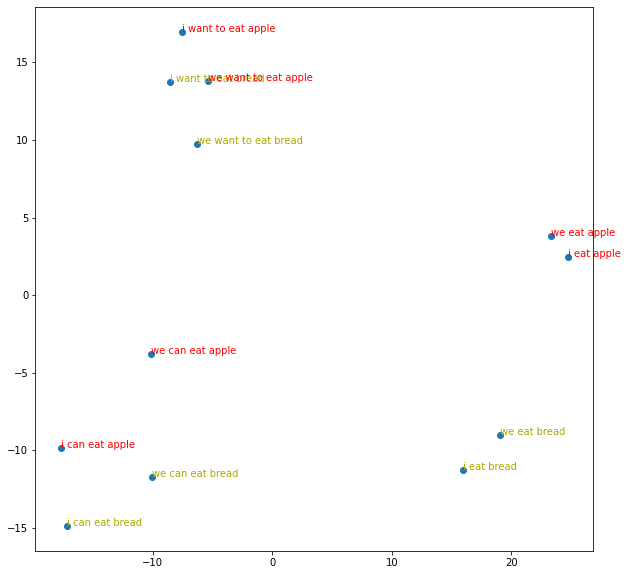

In [11]:
#Lets take sentences with verb eat and ONLY get embedding of verb EAT
#Below are embedding of single verb eat with their sentence
#see how embeddings for them are generated
#results seems nice, we have 3 patterns can,want,verb and seems they are scattered over space
eat_sentences = [ s for s in sentences if s.find("eat") > 0 ]
word_embeddings = [ get_word_embeddings(tokenizer_nottrained,bert_model_nottrained,s,"eat")[0].vector.numpy() for s in eat_sentences ]
dump_on_surface(word_embeddings,eat_sentences,dump_3d=False,fitting="tsne",color_by="object")


In [12]:
#Now I want to see relation of these "eat" vectors,
#these are all eat vectors but having different context
#I will take cosine of every vector with every other,
#so diagonals must be 1(same vectors) and others must show
#the relation. As I see items most unrelated are as below
#we eat apple -> i can eat bread = 0.71 similarity
comparisions = []
for i in range(len(word_embeddings)):
    comparision_row = []
    for j in range(len(word_embeddings)):
        sim = get_similarity(word_embeddings[i],word_embeddings[j])
        comparision_row.append(sim)
    comparisions.append( comparision_row )   
    

pd.options.display.float_format = '{:,.2f}'.format
cm = sns.light_palette("blue", as_cmap=True)
df_eat = pd.DataFrame(data=comparisions ,index=eat_sentences,columns=eat_sentences)
styled_df_eat = df_eat.style.background_gradient(cmap=cm).set_precision(2)
styled_df_eat

,i want to eat bread,i want to eat apple,i can eat bread,i can eat apple,we want to eat bread,we want to eat apple,we can eat bread,we can eat apple,i eat bread,i eat apple,we eat bread,we eat apple
i want to eat bread,1.00,0.96,0.88,0.85,0.96,0.93,0.87,0.86,0.84,0.77,0.81,0.78
i want to eat apple,0.96,1.00,0.85,0.88,0.92,0.95,0.85,0.89,0.81,0.81,0.79,0.80
i can eat bread,0.88,0.85,1.00,0.96,0.87,0.84,0.94,0.90,0.83,0.72,0.79,0.71
i can eat apple,0.85,0.88,0.96,1.00,0.83,0.86,0.91,0.94,0.78,0.73,0.75,0.74
we want to eat bread,0.96,0.92,0.87,0.83,1.00,0.96,0.92,0.89,0.84,0.76,0.87,0.81
we want to eat apple,0.93,0.95,0.84,0.86,0.96,1.00,0.90,0.94,0.81,0.79,0.85,0.85
we can eat bread,0.87,0.85,0.94,0.91,0.92,0.90,1.00,0.96,0.84,0.74,0.88,0.80
we can eat apple,0.86,0.89,0.90,0.94,0.89,0.94,0.96,1.00,0.79,0.77,0.83,0.84
i eat bread,0.84,0.81,0.83,0.78,0.84,0.81,0.84,0.79,1.00,0.87,0.93,0.83
i eat apple,0.77,0.81,0.72,0.73,0.76,0.79,0.74,0.77,0.87,1.00,0.84,0.91


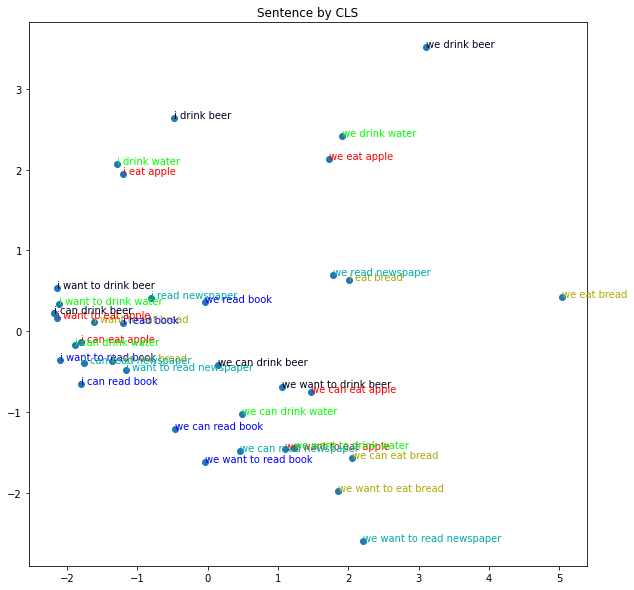

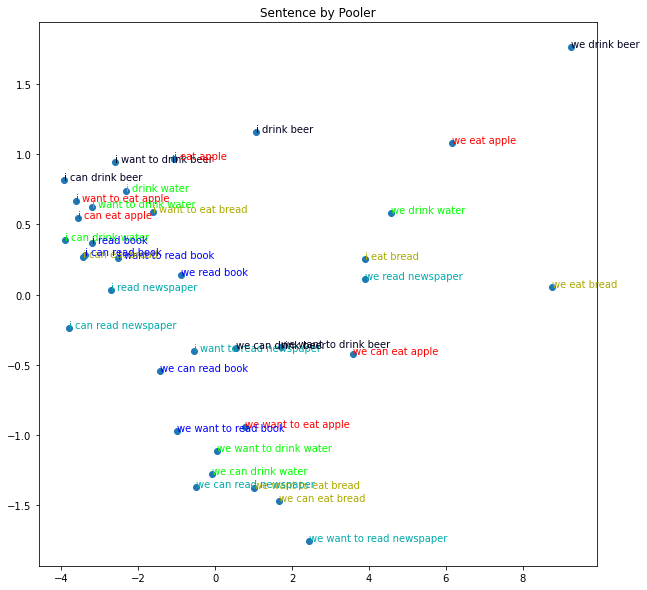

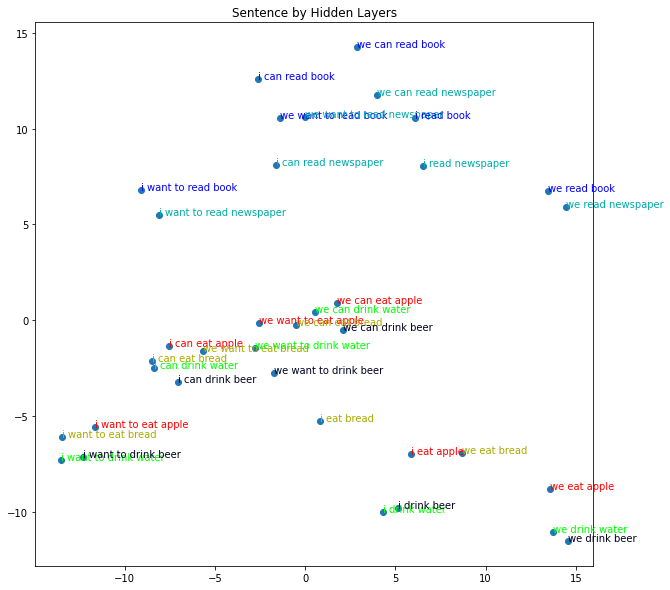

In [13]:
#For sentence embedding we can try 3 approaches
#According to your problem best approach can change.
#At internet I read CLS is not a good solution if u dont train CLS for your task.

#1)Get CLS as sentence embedding
outputs = [ get_bert_output_cls(tokenizer_nottrained,bert_model_nottrained,s).detach().numpy() for s in sentences]
dump_on_surface(outputs,sentences,fitting="pca",dump_3d=False,dump_2d=True,color_by="object",title="Sentence by CLS")

#2)Get Pooler layer output
outputs = [ get_bert_output_pooled(tokenizer_nottrained,bert_model_nottrained,s).detach().numpy() for s in sentences]
dump_on_surface(outputs,sentences,fitting="pca",dump_3d=False,dump_2d=True,color_by="object",title="Sentence by Pooler")

#3)Get a combination of hidden layers
outputs = [ get_sentence_embedding(tokenizer_nottrained,bert_model_nottrained,s,type="meansum").detach().numpy() for s in sentences]
dump_on_surface(outputs,sentences,fitting="pca",dump_3d=False,dump_2d=True,color_by="object",title="Sentence by Hidden Layers")

#I think 3rd method , Hidden Layers seems best, because eat and drink are more near
#it makes sense when they are near

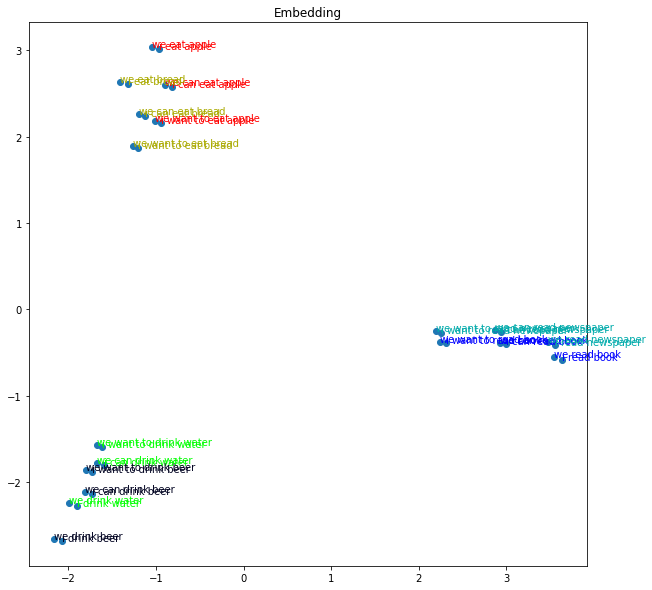

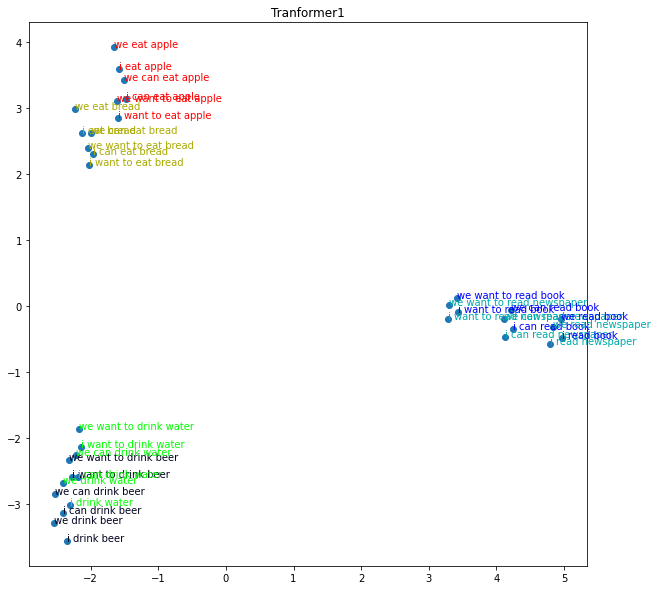

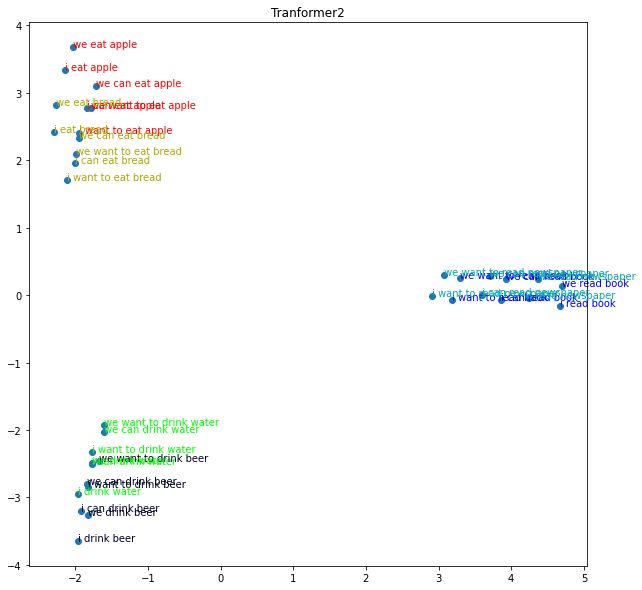

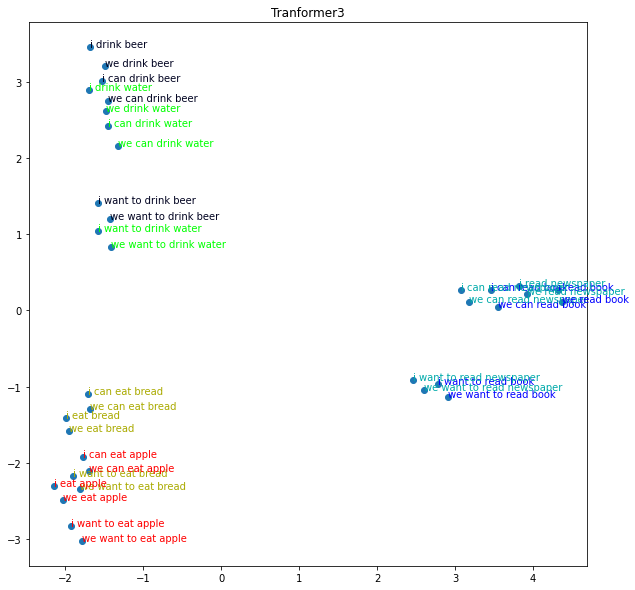

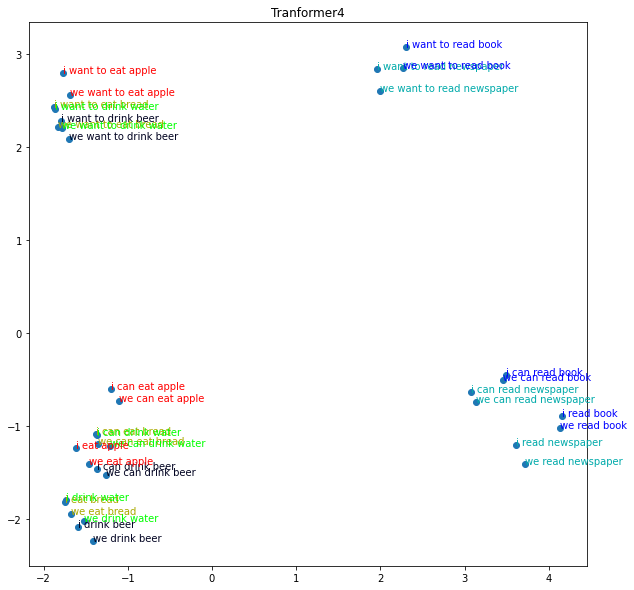

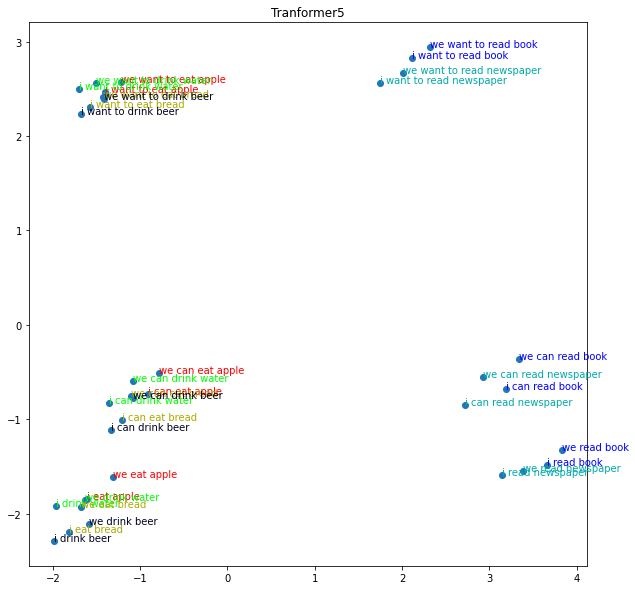

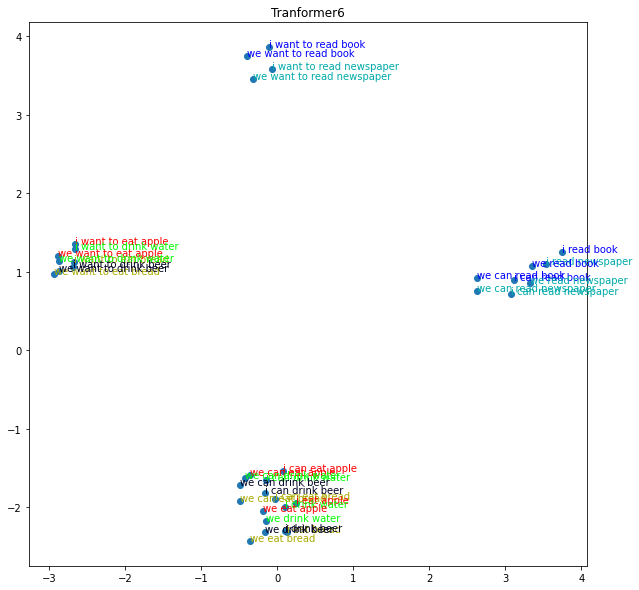

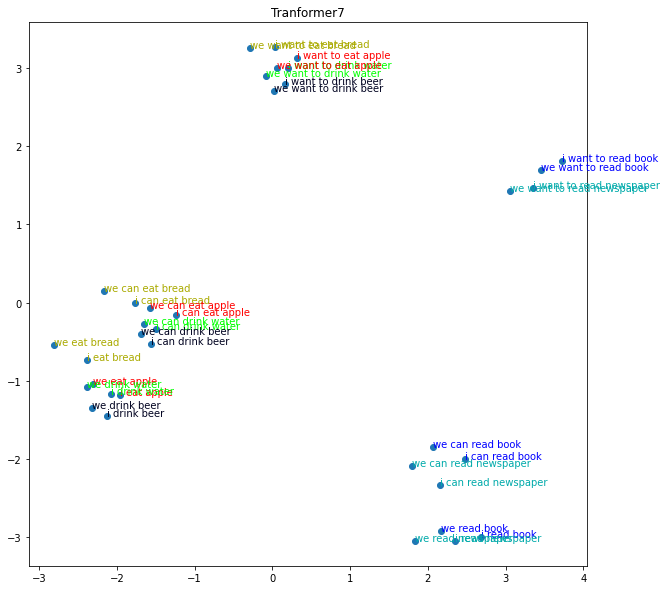

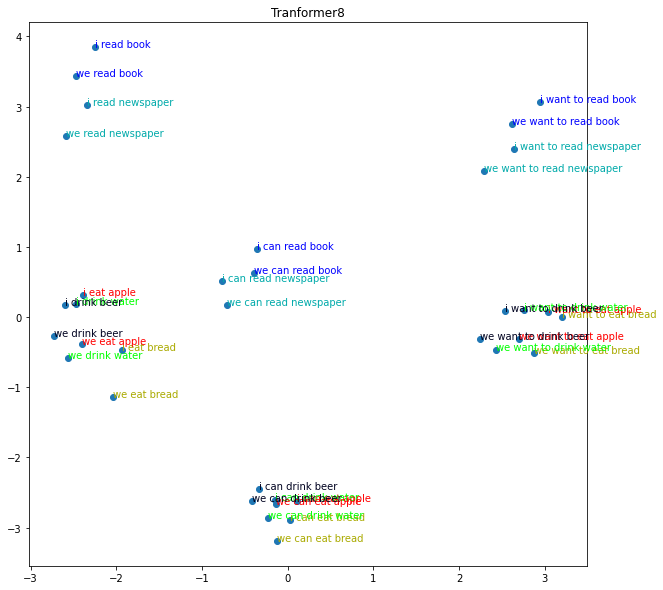

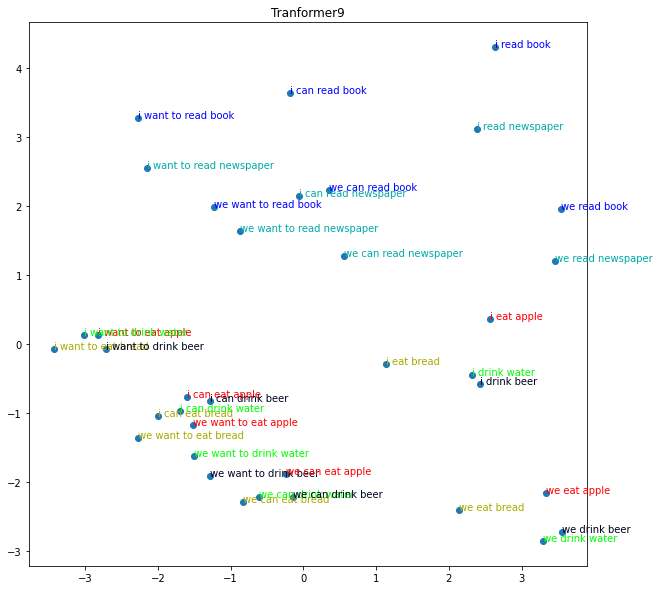

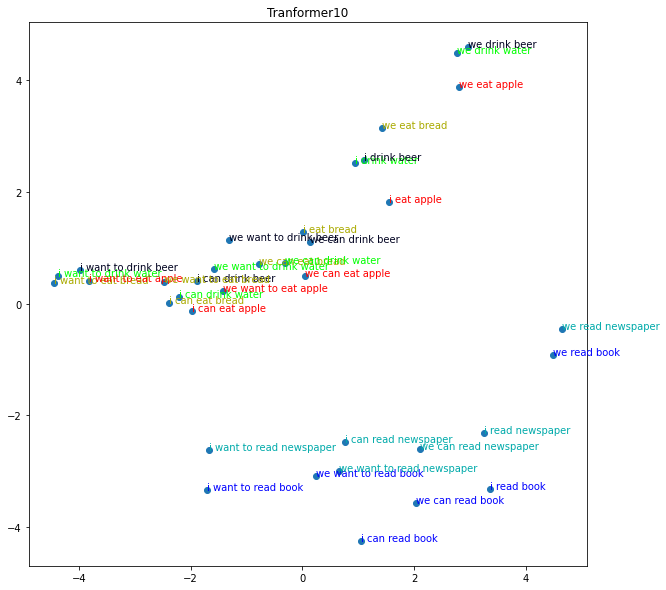

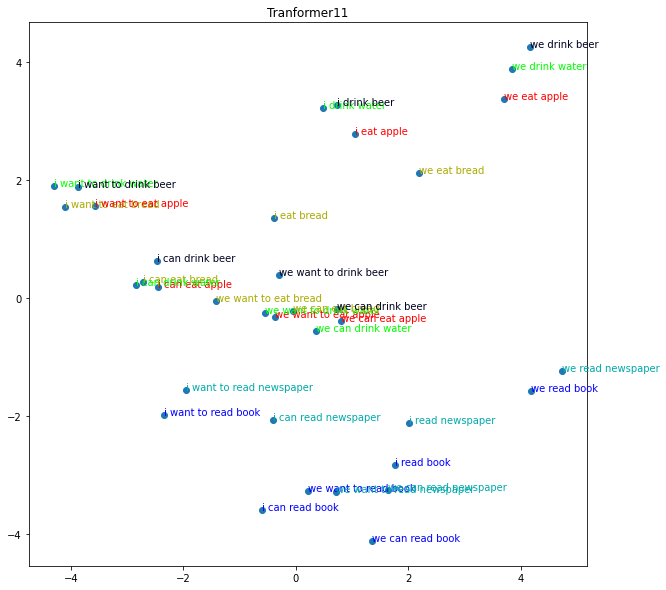

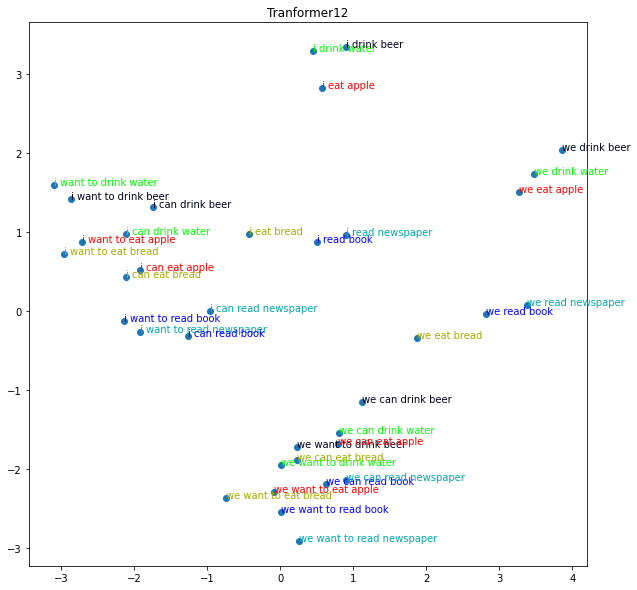

In [14]:
#Now I want to see what all hidden layers are generating
#Infact at first layers , groups are more clear,
#But at the end everything gets more closer.
for i in range(13):
    title = "Tranformer"+str(i) if i > 0 else "Embedding"
    pooler_outputs = [ get_sentence_embedding(tokenizer_nottrained,bert_model_nottrained,s,layer_start=i,layer_end=i+1,type="meanmean").detach().numpy() for s in sentences]
    #pooler_outputs = [ get_sentence_embedding(tokenizer_nottrained,bert_model_nottrained,s,layer_start=i,layer_end=i+1,type="meansum").detach().numpy() for s in sentences]
    #show_embeddings([],[],pooler_outputs,sentences,fitting="pca")
    dump_on_surface(pooler_outputs,sentences,fitting="pca",dump_3d=False,dump_2d=True,color_by="object",title=title)

In [15]:
#utility methods for creating dataframe
def get_group_by_object(s):
    objects = ["apple","bread","water","beer","book","newspaper"]
    for index,obj in enumerate(objects):
        if s.find(obj) > 0:
            return index

def get_group_by_verb(s):
  if s.find("drink") > 0:
    return 0
  elif s.find("eat") > 0:
    return 1
  else:
    return 2        
        
def get_df_by_object():
    df = pd.DataFrame()
    df["Sentence"] = sentences
    df["Group"] = [ get_group_by_object(s) for s in sentences]
    return df

def get_df_by_verb():
    df = pd.DataFrame()
    df["Sentence"] = sentences
    df["Group"] = [ get_group_by_verb(s) for s in sentences]
    return df

In [16]:
input_df = None
CLASS_NUMS = None

input_df = get_df_by_verb()
CLASS_NUMS = 3

#If you want to run the code for object uncomment 2 below lines
#input_df = get_df_by_object()
#CLASS_NUMS = 6

input_df.head(10)

,Sentence,Group
0,i want to eat bread,1
1,i want to eat apple,1
2,i want to drink water,0
3,i want to drink beer,0
4,i want to read book,2
5,i want to read newspaper,2
6,i can eat bread,1
7,i can eat apple,1
8,i can drink water,0
9,i can drink beer,0


In [17]:
# Sections of config

# Defining some key variables that will be used later on in the training

TRAIN_BATCH_SIZE = 4
#VALID_BATCH_SIZE = 4

LEARNING_RATE = 1e-05
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased', truncation=True, do_lower_case=True)


In [18]:
class SentimentData(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.text = dataframe.Sentence
        self.targets = self.data.Group
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = str(self.text[index])
        target = self.targets[index]

        return text,target

In [19]:
train_size = 1
train_data=input_df.sample(frac=train_size,random_state=200)
test_data= train_data # input_df.drop(train_data.index).reset_index(drop=True)
train_data = train_data.reset_index(drop=True)


print("FULL Dataset: {}".format(input_df.shape))
print("TRAIN Dataset: {}".format(train_data.shape))
print("TEST Dataset: {}".format(test_data.shape))

training_set = SentimentData(train_data, tokenizer, MAX_LEN)
testing_set = SentimentData(test_data, tokenizer, MAX_LEN)

FULL Dataset: (36, 2)
TRAIN Dataset: (36, 2)
TEST Dataset: (36, 2)


In [20]:
train_params = {'batch_size': 4,'shuffle': True,'num_workers': 0}

#test_params = {'batch_size': VALID_BATCH_SIZE,'shuffle': True,'num_workers': 0}

training_loader = DataLoader(training_set, **train_params)
#testing_loader = DataLoader(training_set, **test_params)

In [21]:



class BertClassifier(torch.nn.Module):
    def __init__(self,nntokenizer,nn_bert_model):
        super(BertClassifier, self).__init__()
        nn_bert_model.train()
        self.nn_bert_model = nn_bert_model 
        self.nntokenizer = nntokenizer
        
        #self.pre_classifier = torch.nn.Linear(768, 768)
        #self.dropout = torch.nn.Dropout(0.1)
        self.classifier = torch.nn.Linear(768, CLASS_NUMS)

    def forward(self, sentence_list):
        bert_embeddings = [get_bert_output_pooled(self.nntokenizer,self.nn_bert_model,s) for s in sentence_list ]
        pooler = torch.stack(bert_embeddings)
        
        #pooler = self.pre_classifier(pooler)
        #pooler = torch.nn.ReLU()(pooler)
        #pooler = self.dropout(pooler)
        
        output = self.classifier(pooler)
        return output

In [22]:
#def calcuate_accuracy(preds, targets):
#    n_correct = (preds==targets).sum().item()
#    return n_correct

In [23]:
def train(epoch):

    correct_predictions = 0
    model.train()
    for _,data in tqdm(enumerate(training_loader, 0)):
        #get data and labels
        sentence_batch = data[0]
        targets = data[1].to(device, dtype = torch.long)
        #call network forward and calculate loss
        outputs = model(sentence_batch)
        loss = loss_function(outputs, targets)
        #get predictions and compare with actual        
        _, predicted_groups = torch.max(outputs.data, dim=1)        
        correct_predictions += (predicted_groups  == targets).sum().item()
            
        #do backpropagation    
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    epoch_accu = int( ( correct_predictions * 100 )/len(sentences) )        

    return epoch_accu

In [24]:

bert_model = BertModel.from_pretrained('bert-base-uncased',output_hidden_states = True )
model = BertClassifier(tokenizer,bert_model)
bert_model.train()
_ = model.to(device)
# Creating the loss function and optimizer
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

EPOCHS = 8
for epoch in range(EPOCHS):
    epoch_accu = train(epoch)
    print(f"At Epoch {epoch+1}  Accuracy : {epoch_accu}")
    if epoch_accu > 97:
        break

9it [00:29,  3.28s/it]
0it [00:00, ?it/s]

At Epoch 1  Accuracy : 38


9it [00:26,  2.89s/it]
0it [00:00, ?it/s]

At Epoch 2  Accuracy : 80


9it [00:25,  2.86s/it]
0it [00:00, ?it/s]

At Epoch 3  Accuracy : 88


9it [00:29,  3.25s/it]
0it [00:00, ?it/s]

At Epoch 4  Accuracy : 97


9it [00:27,  3.07s/it]

At Epoch 5  Accuracy : 100


In [25]:
#put Bert trained model into eval mode
_ = bert_model.eval()

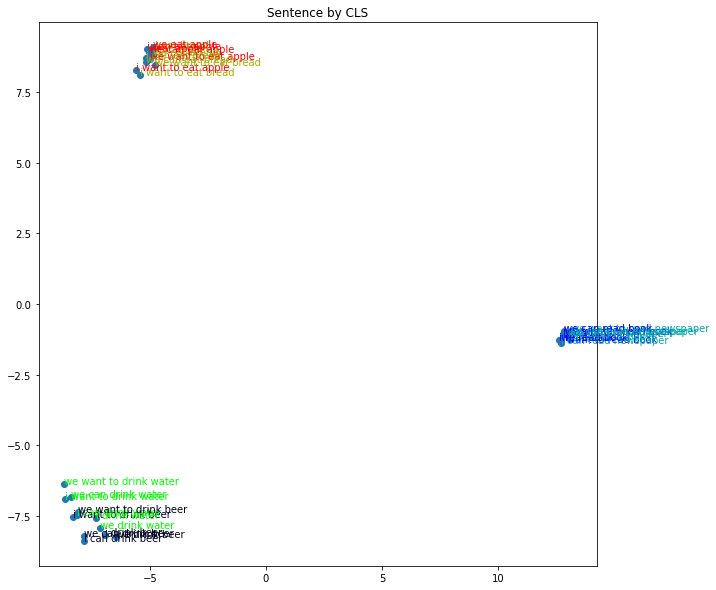

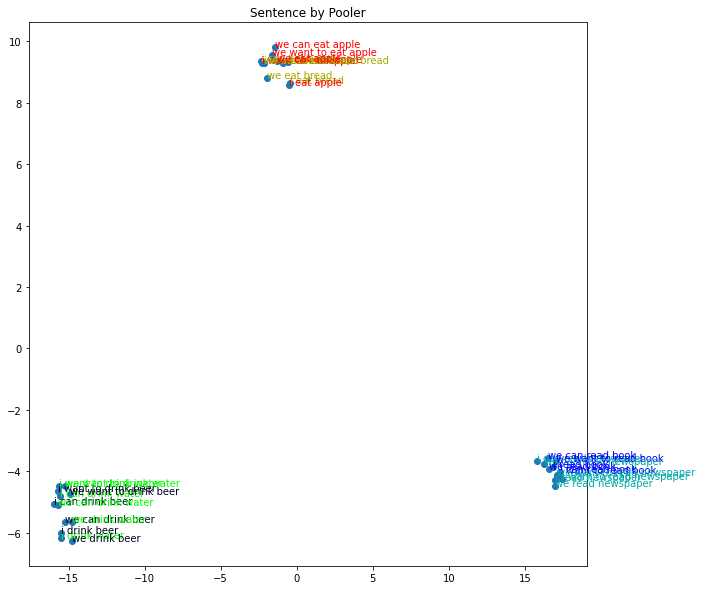

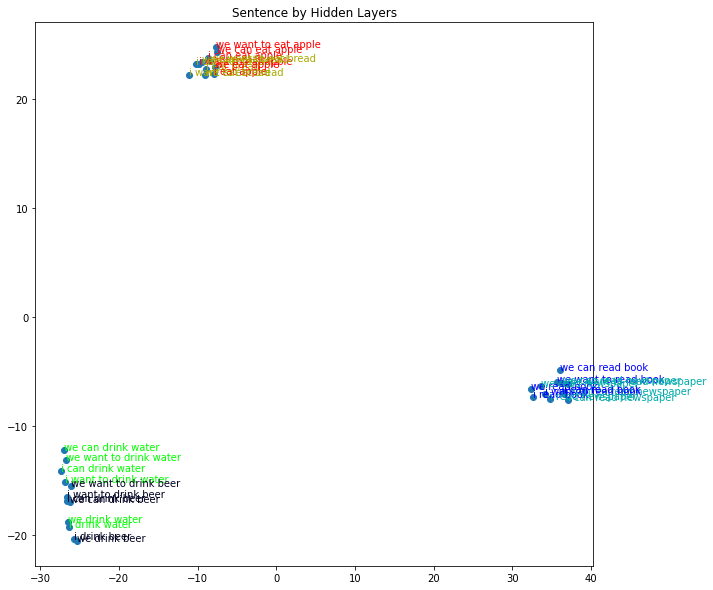

In [26]:
#For sentence embedding we can try 3 approaches
#According to your problem best approach can change.
#At internet I read CLS is not a good solution if u dont train CLS for your task.

#1)Get CLS as sentence embedding
outputs = [ get_bert_output_cls(tokenizer,bert_model,s).detach().numpy() for s in sentences]
dump_on_surface(outputs,sentences,fitting="pca",dump_3d=False,dump_2d=True,color_by="object",title="Sentence by CLS")

#2)Get Pooler layer output
outputs = [ get_bert_output_pooled(tokenizer,bert_model,s).detach().numpy() for s in sentences]
dump_on_surface(outputs,sentences,fitting="pca",dump_3d=False,dump_2d=True,color_by="object",title="Sentence by Pooler")

#3)Get a combination of hidden layers
outputs = [ get_sentence_embedding(tokenizer,bert_model,s,type="meansum").detach().numpy() for s in sentences]
dump_on_surface(outputs,sentences,fitting="pca",dump_3d=False,dump_2d=True,color_by="object",title="Sentence by Hidden Layers")


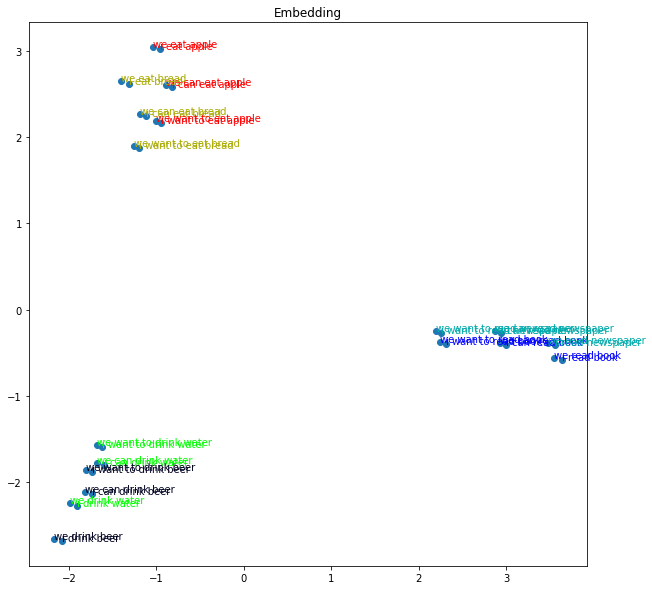

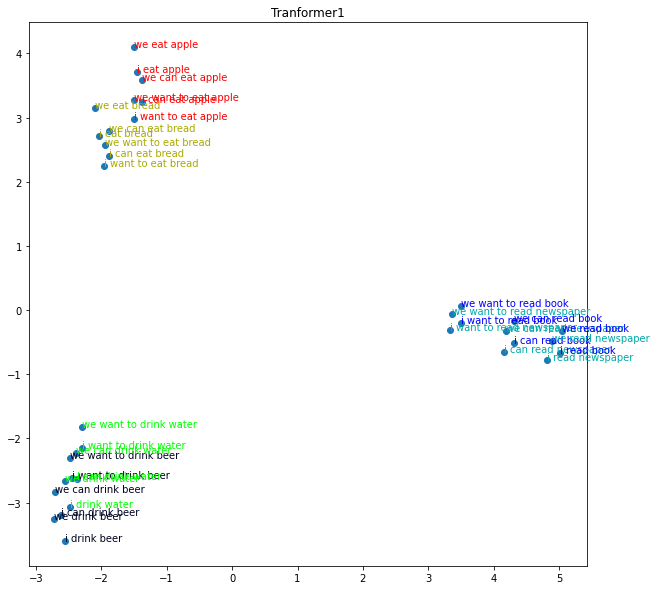

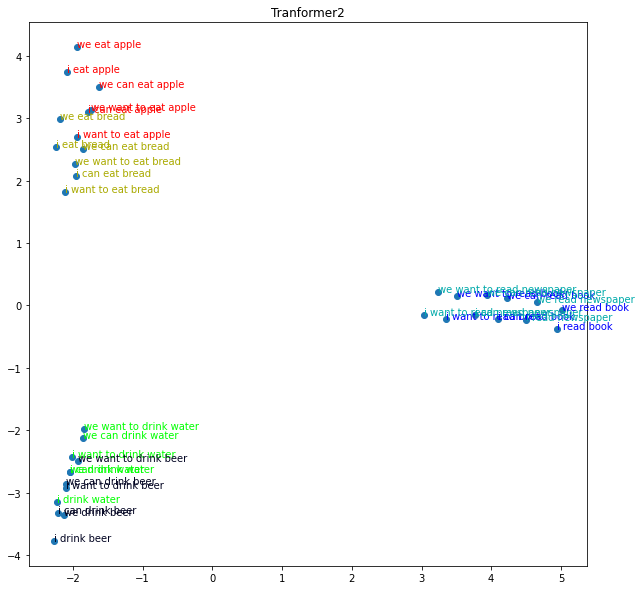

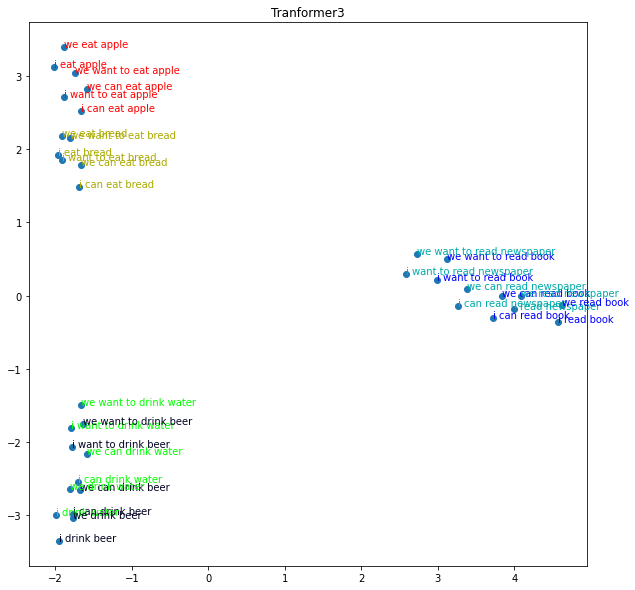

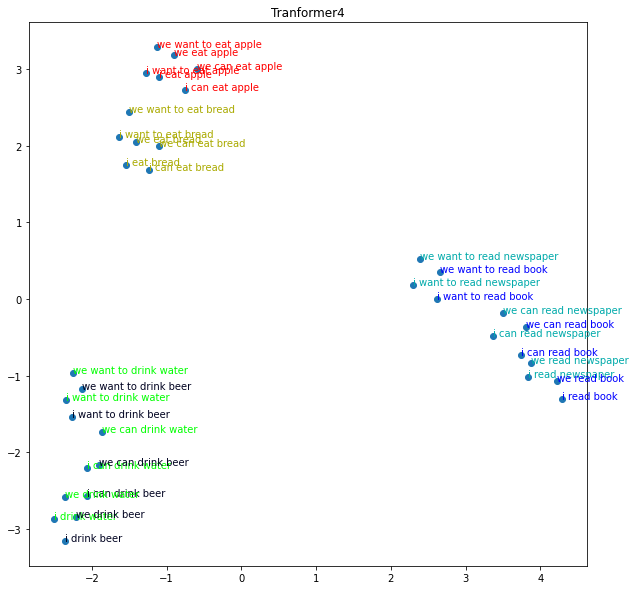

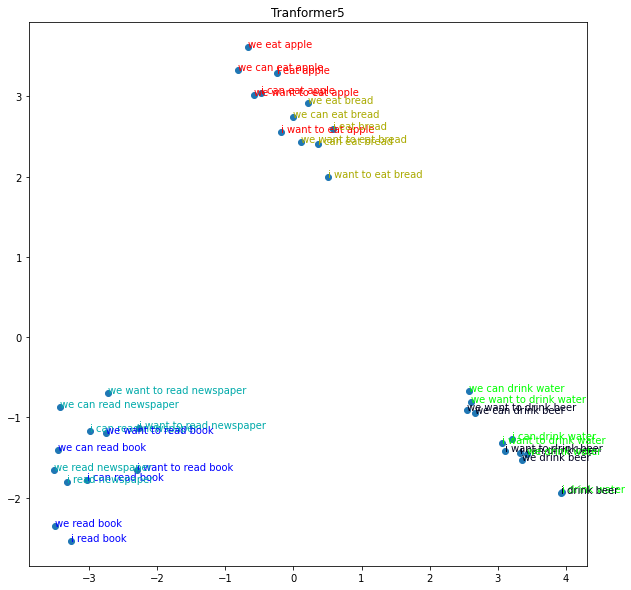

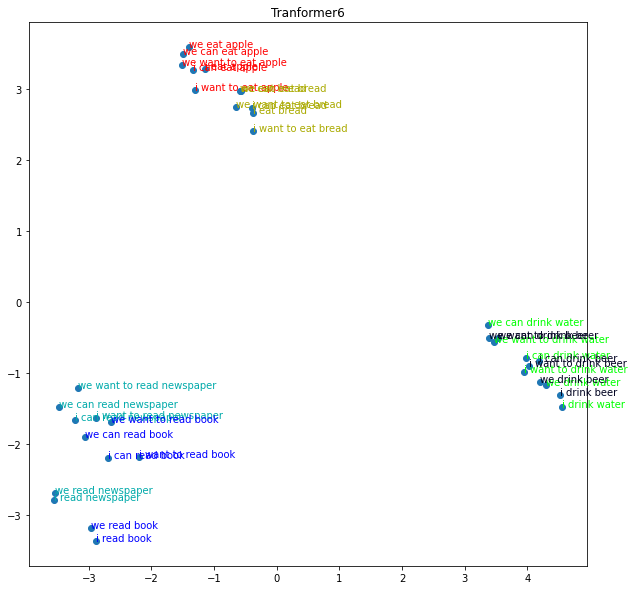

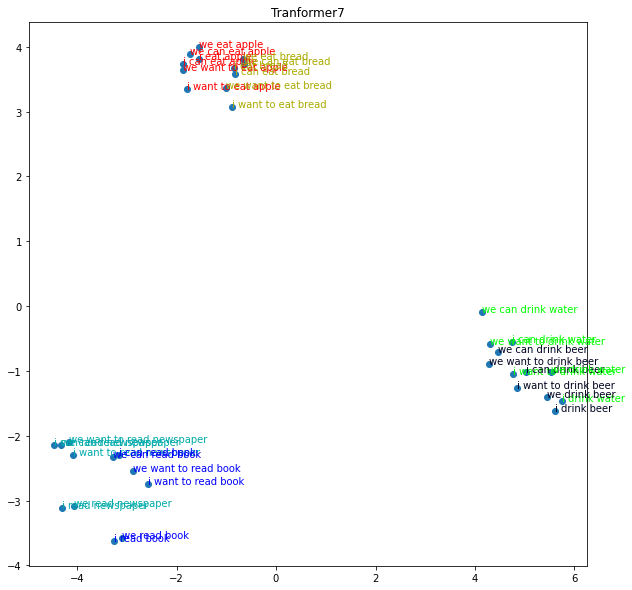

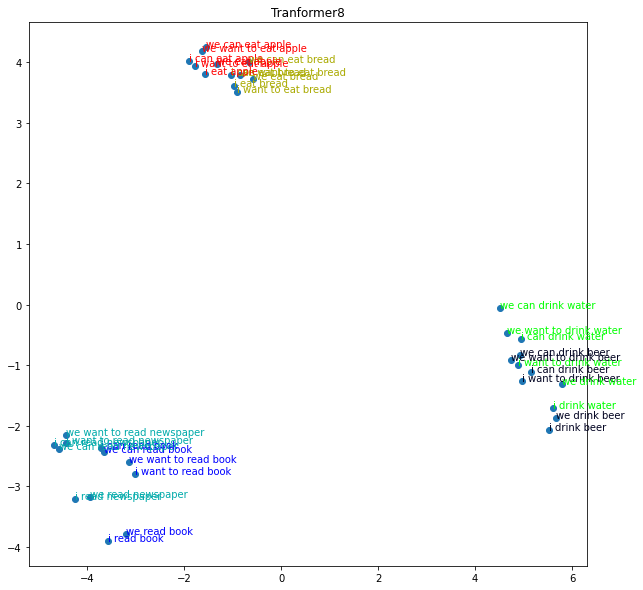

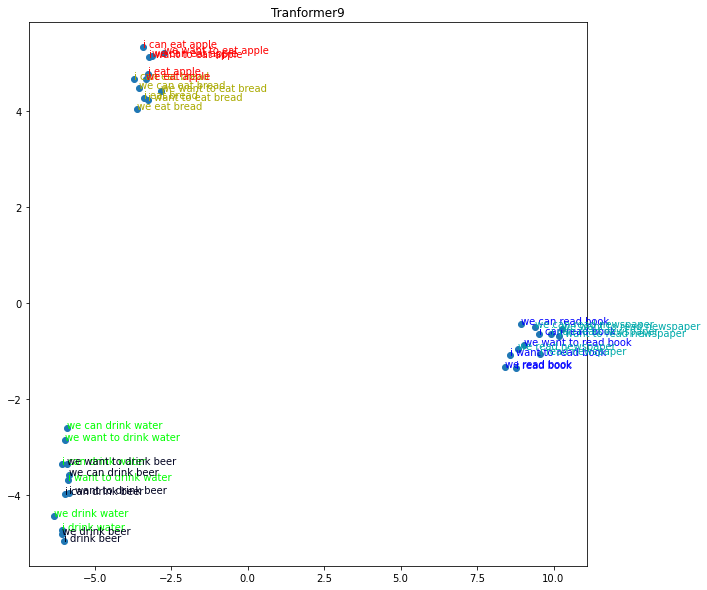

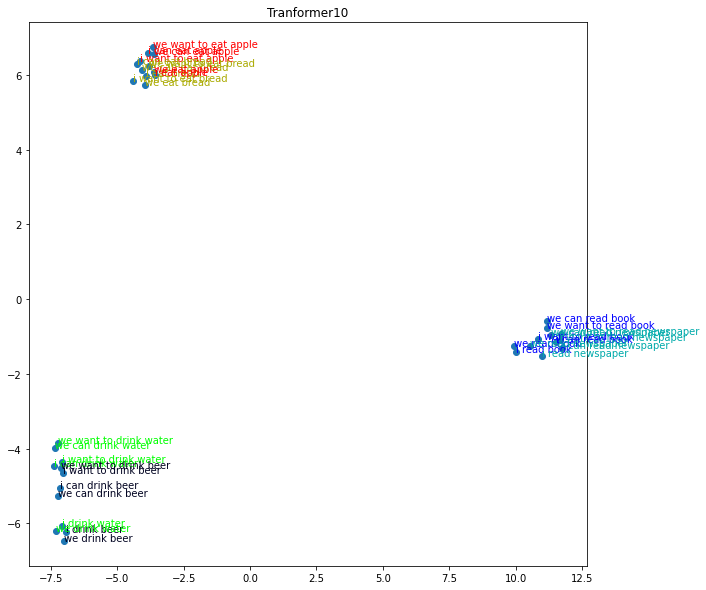

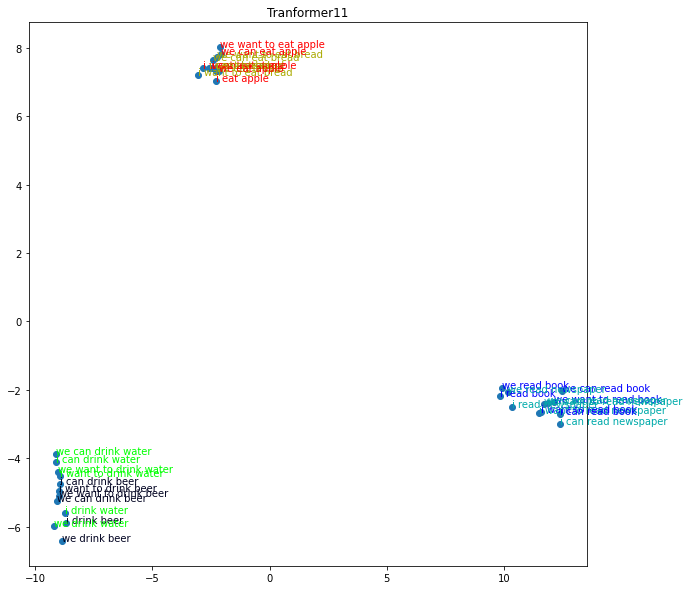

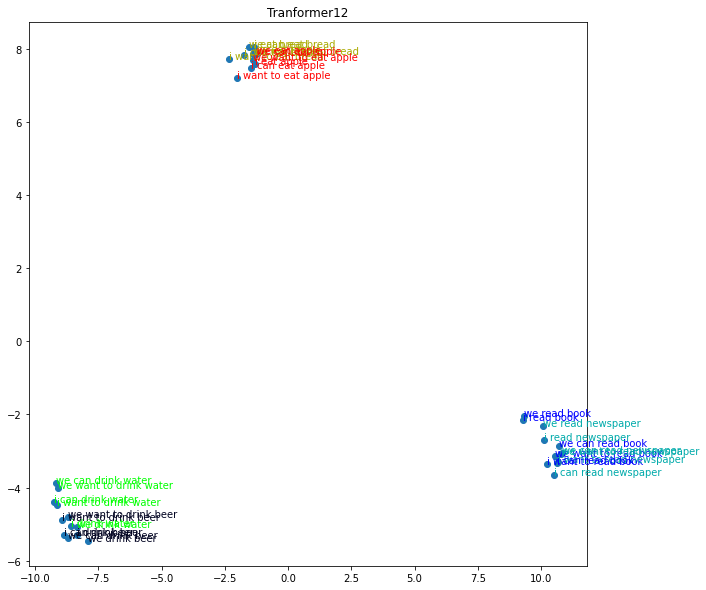

In [27]:
#Now I want to see what all hidden layers are generating
#Infact at first layers , groups are more clear,
#But at the end everything gets more closer.
for i in range(13):
    title = "Tranformer"+str(i) if i > 0 else "Embedding"
    pooler_outputs = [ get_sentence_embedding(tokenizer,bert_model,s,layer_start=i,layer_end=i+1,type="meanmean").detach().numpy() for s in sentences]
    #pooler_outputs = [ get_sentence_embedding(tokenizer_nottrained,bert_model_nottrained,s,layer_start=i,layer_end=i+1,type="meansum").detach().numpy() for s in sentences]
    #show_embeddings([],[],pooler_outputs,sentences,fitting="pca")
    dump_on_surface(pooler_outputs,sentences,fitting="pca",dump_3d=False,dump_2d=True,color_by="object",title=title)

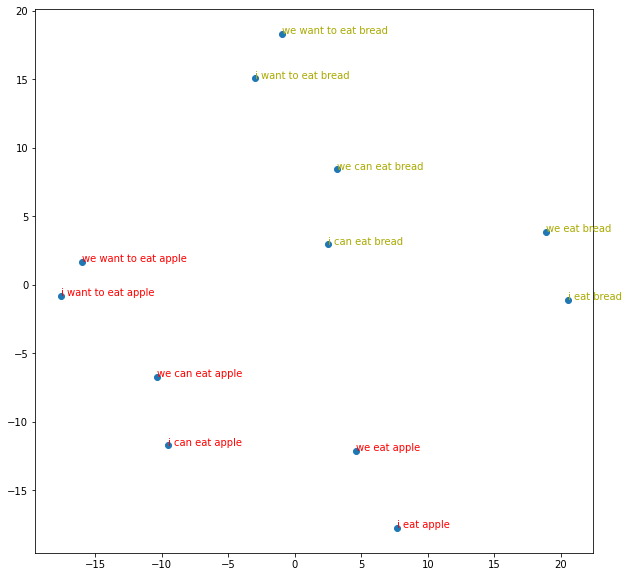

In [28]:
#Lets take sentences with verb eat and ONLY get embedding of verb EAT
#Below are embedding of single verb eat with their sentence
#see how embeddings for them are generated
#results seems nice, we have 3 patterns can,want,verb and seems they are scattered over space
eat_sentences = [ s for s in sentences if s.find("eat") > 0 ]
word_embeddings = [ get_word_embeddings(tokenizer,bert_model,s,"eat")[0].vector.numpy() for s in eat_sentences ]
dump_on_surface(word_embeddings,eat_sentences,dump_3d=False,fitting="pca",color_by="object")


In [29]:
#Now I want to see relation of these "eat" vectors,
#these are all eat vectors but having different context
#I will take cosine of every vector with every other,
#so diagonals must be 1(same vectors) and others must show
#the relation. As I see items most unrelated are as below
#we eat apple -> i can eat bread = 0.71 similarity

comparisions = []
for i in range(len(word_embeddings)):
    comparision_row = []
    for j in range(len(word_embeddings)):
        sim = get_similarity(word_embeddings[i],word_embeddings[j])
        comparision_row.append(sim)
    comparisions.append( comparision_row )   
    
pd.options.display.float_format = '{:,.2f}'.format
cm = sns.light_palette("blue", as_cmap=True)

df = pd.DataFrame(data=comparisions ,index=eat_sentences,columns=eat_sentences)
styled_df = df.style.background_gradient(cmap=cm).set_precision(2)
styled_df

,i want to eat bread,i want to eat apple,i can eat bread,i can eat apple,we want to eat bread,we want to eat apple,we can eat bread,we can eat apple,i eat bread,i eat apple,we eat bread,we eat apple
i want to eat bread,1.00,0.94,0.92,0.88,0.97,0.92,0.92,0.89,0.90,0.86,0.89,0.86
i want to eat apple,0.94,1.00,0.87,0.93,0.91,0.98,0.87,0.93,0.83,0.89,0.82,0.90
i can eat bread,0.92,0.87,1.00,0.95,0.89,0.85,0.95,0.91,0.91,0.88,0.87,0.86
i can eat apple,0.88,0.93,0.95,1.00,0.85,0.90,0.91,0.96,0.86,0.92,0.82,0.90
we want to eat bread,0.97,0.91,0.89,0.85,1.00,0.93,0.95,0.90,0.88,0.84,0.92,0.88
we want to eat apple,0.92,0.98,0.85,0.90,0.93,1.00,0.90,0.95,0.82,0.87,0.85,0.92
we can eat bread,0.92,0.87,0.95,0.91,0.95,0.90,1.00,0.95,0.89,0.86,0.93,0.90
we can eat apple,0.89,0.93,0.91,0.96,0.90,0.95,0.95,1.00,0.84,0.91,0.87,0.94
i eat bread,0.90,0.83,0.91,0.86,0.88,0.82,0.89,0.84,1.00,0.94,0.95,0.90
i eat apple,0.86,0.89,0.88,0.92,0.84,0.87,0.86,0.91,0.94,1.00,0.90,0.96
